# NESM Python Workshop Part 3


## Overview

Goals:
We can't cover every use case in detail so the main goals here are:
1. Demonstrate that you can do microscopy analysis completely from python
2. Give a quick tour of the some of the many open source libs (set you up for future success)
3. Go over some domain specific examples
    - reinforce the numpy we learned in part 1
    - Show power of the open source ecosystem
    - Building blocks are all here and numpy is the commmon language of these tools

- Microscopy Image IO


### Scripts vs GUIs

## Image analysis tools

Python has a rich ecosystem of libraries
- [scipy.ndimage](https://docs.scipy.org/doc/scipy/reference/tutorial/ndimage.html)
- [skimage](https://scikit-image.org/docs/dev/api/skimage.html)
- [sklearn](https://scikit-learn.org/stable/)
- [xarray](http://xarray.pydata.org/en/stable/)
- [pandas](https://pandas.pydata.org/)


Domain Specific tools:

- [hyperspy](https://hyperspy.org/hyperspy-doc/current/user_guide/intro.html)
- [microutil](https://github.com/Hekstra-Lab/microutil)
- https://github.com/LeBeauGroup/usetem
**Deep Learning:**
The two world class libraries are both primarily python:
- https://pytorch.org/
- https://www.tensorflow.org/  (we'll see an example later)



Visualization

## [Napari](https://napari.org/)
    
    
The future of microscopy image visualization. 

- Tools like Matplotlib will always have a place in the workflow, but Napari is a best in class image viewer that also 

GPU accelerated
Core developers work in bioimaging
Open source with a strong community of contributors
vs hyperslicer - 


https://www.youtube.com/watch?v=VXdFOcBCto4


Let's you work anywhere on the spectrum from pure gui to pure script no interactivity.

## IO

Not always a fully solved problem due to to proprietary formats. 

Libraries exist where people have put in the work to read all the possible types of images. 


Rock solid base: https://github.com/cgohlke/tifffile  
https://github.com/tlambert03/ome-types  
The future (and maybe also the now?): https://allencellmodeling.github.io/aicsimageio/  


Per https://ngff.openmicroscopy.org/latest/ [zarr](https://zarr.readthedocs.io/en/stable/) will be the basis of the next generation file format.

In [ ]:
%matplotlib widget
import xarray as xr
from mpl_interactions import hyperslicer
import matplotlib.pyplot as plt
import mpl_interactions.ipyplot as iplt
import tifffile
import numpy as np



# Looking at an Example SEM image

Kindly provided by JEOL.

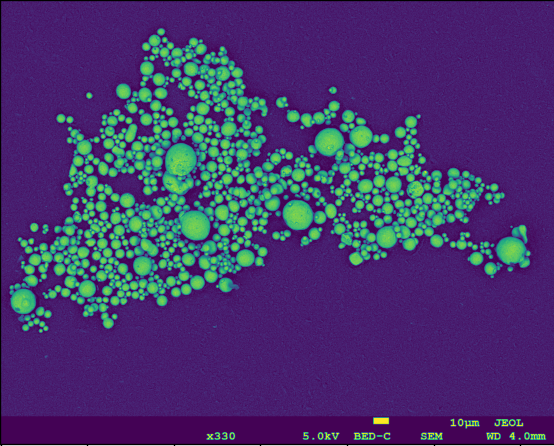

We'd like to be able to reproduce something like this:

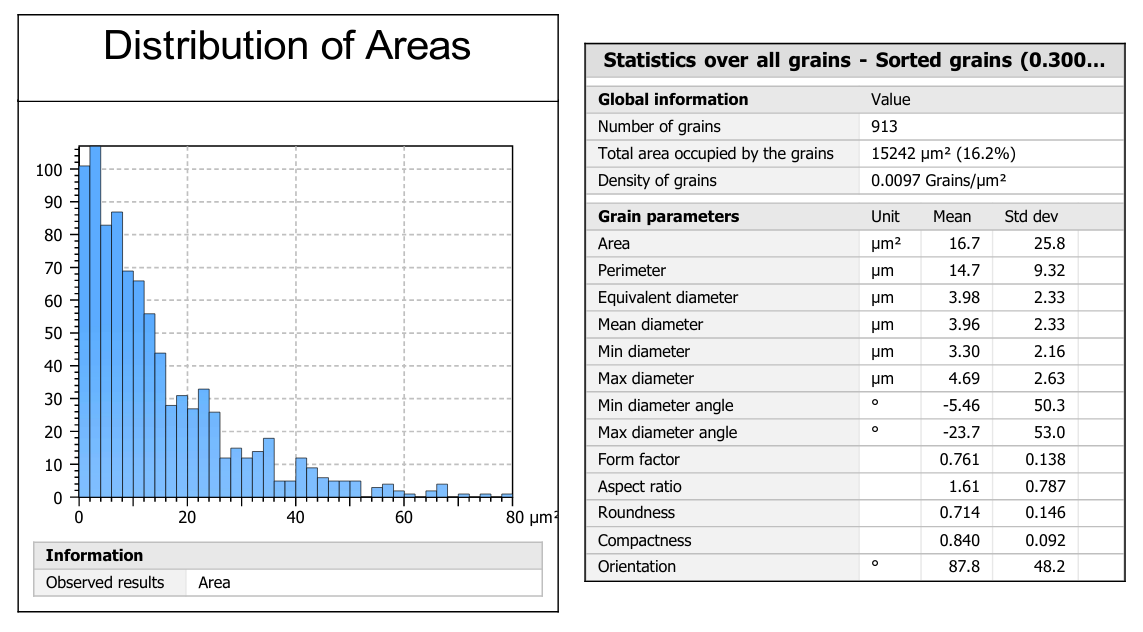


In [ ]:
# load the data using `tifffile`
particles_raw = tifffile.imread("../data/Particle.tif")
fig, ax =  plt.subplots()
ax.imshow(particles_raw)

### Extracting Scale Bar

There are two ways to get the information from the scale bar so that we know the conversion from pixels to microns. The first (and preferable) way is to use the metadata in associated `particles.txt` file.

The second way is to directly extract the information from the image. By looking at the image we can see that the scale bar is 10 $\mu m$ so if we can extract how long the scale bar is in pixel we can get the conversion.

#### From the metadata file

In this case I just looked inside the metadata file and read the values.

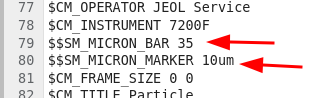


If you were doing this in bulk then you could extract this in bulk using code.

In [ ]:
scale_bar_length_pixels = 35
scale_bar_length_micron = 10
pixels_per_micron = scale_bar_length_pixels / scale_bar_length_micron
microns_per_pixel = 1 / pixels_per_micron

### Extracting from the image.

This is a bit case specific but demonstrates the versatility of these tools. Feel free to skip this section.


The approach here is to extract the pixel values in a horizontal line through the scale bar and see how many pixels it takes to drop off.

In [ ]:
# subset the array - I already looked and know that these values are good
arr = particles_raw[960:, 850:900]

# take a line that we know is the bar
bar = arr[10, :]

fig, axs = plt.subplots(2,1)
axs[0].imshow(arr)
axs[1].plot(bar, "o-")

# do the indexing to figure how many pixels long the bar is
idxs = np.arange(len(bar))[bar > 10]
scale_bar_length_pixels = idxs.max() - idxs.min()
scale_bar_length_micron = 10 # we know 10 micron from the image
pixels_per_micron = scale_bar_length_pixels / scale_bar_length_micron
microns_per_pixel = 1 / pixels_per_micron

Now that we have this physical dimension information it is nice to keep it along with the array. So we will use an `xarray.DataArray`

In [ ]:
# create an xarray DataArray

particles = particles_raw[:960]
particles = xr.DataArray(
    particles,
    dims=("Y", "X"),
    coords={
        "Y": np.linspace(0, particles.shape[0] * microns_per_pixel, particles.shape[0]),
        "X": np.linspace(0, particles.shape[1] * microns_per_pixel, particles.shape[1])
    },
)
particles

We can use the xarray methods to plot the image with approriate dimension information 

In [ ]:
fig, ax = plt.subplots()
xr.plot.imshow(particles)
ax.set_xlabel('X (micron)')
ax.set_ylabel('Y (micron)')

## Thresholding

The first step in the analysis pipeline for this image is to determine a threshold value and make a thresholded image.

### Interactively


Sometimes it's nice to make a human judgement. This is easy to do using existing tools in the python ecosystem.  Here we use code taken nearly verbatim from an example on https://mpl-interactions.readthedocs.io/en/stable/examples/range-sliders.html#Using-a-RangeSlider-for-Scalar-arguments---Thresholding-an-Image


The only difference is that sometimes when using `xarray` functions will not work properly and we need to access the underlying `numpy` array that xarray stores. We can access this via the `.values` attribute.

To make it easy to use we've also wrapped it up into a function that we can call easily on an array.

In [ ]:
import mpl_interactions.ipyplot as iplt

from nesm_utils import interactive_threshold

controls, axes = interactive_threshold(particles.values, bins=np.arange(0, 255))

In [ ]:
# then you can access the current values of the parameters via `controls.params`
controls.params

In [ ]:
thresholded_image = particles > 88 # value chosen by interactive thresholding
fig, ax = plt.subplots()
ax.imshow(thresholded_image)


### Keeping the mask and original image together

Our lives will be much easier if we keep our parts of the analysis pipeline together. For this we make use of an `xarray.Dataset`.

In [ ]:
ds = xr.Dataset({'image': particles})

In [ ]:
ds['mask'] = thresholded_image
ds

Now we can access the arrays inside of the dataset by indexing using square brackets.

In [ ]:
ds['image']

## Breakout Exercise

Interactively choosing thresholds does not scale 

1. Make a plot comparing multiple thresholding methods (https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_thresholding.html)
    - Hint: You may need to use `particles.values` as xarray is not always completely interoperable with skimage
2. Segment the particles into individual labels
    - I would google something like: `segment particles skimage`
    - `skimage.measure.label` is appealing but isn't the optimal function.
3. Make a histogram of area of the particles
    - Any of these functions will let you get the areas
         - `np.unique`
         - `ndi.sum_labels`
         - `skimage.measure.regionprops`
    - Make a histogram using `plt.hist`

If you finish all of that experiment with using `skimage.morphology.remove_small_objects` and `skimage.segmentation.relabel_sequential` to clean up any noise we may have let through when thesholding.

#### 1.

From the linked tutorial I found the function `try_all_threshold` and just copied the example and then modified the input array to fit our usecase.

In [ ]:
from skimage.filters import try_all_threshold

fig, ax = try_all_threshold(particles.values, figsize=(10, 8), verbose=False)
plt.show()

From this we learned that several of the automated thresholding algorithms will work for our dataset. So if we were analyzing many images we could loop over the images and apply one of these to automatically threshold it.

#### 2. Segmenting

Watershed segmentation is a good first choice when exploring segmentation of an image. To do this I googled around phrases such as:

`skimage watershed segmentation` until I found this tutorial: https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_watershed.html. Then I took the approach of fully copying the known working example and slowly modifying it until it fit my use case exactly.


Sidenote: If you can find a pretrained neural net to do the segmentation it will almost certainly work better - however that is far more computationally expensive and so 

In [ ]:
import scipy.ndimage as ndi
from skimage.feature import peak_local_max
from skimage.filters import threshold_otsu
from skimage.segmentation import watershed

threshold = threshold_otsu(ds["image"].values)
ds["mask"] = ds["image"] > threshold


distance = ndi.distance_transform_edt(ds["mask"].values)
coords = peak_local_max(distance, min_distance=2)
mask = np.zeros(distance.shape, dtype=bool)
mask[tuple(coords.T)] = True
markers, _ = ndi.label(mask)
ds["labels"] = (("Y", "X"), watershed(-distance, markers, mask=ds["mask"].values))


# plt.figure()
# plt.imshow(ds["mask"])

# plt.figure()
# plt.imshow(distance)

# We will use a custom colormap for segmentation
# The code for generating this is inside of nesm_utils
from nesm_utils import get_segment_cmap

fig, ax = plt.subplots()
ax.imshow(ds["image"], cmap="gray_r")
ax.imshow(ds["labels"], cmap=get_segment_cmap(ds["labels"]))
ax.set_title("Segmented Image")

This doesn't give a perfect segmentation. To do better we could tune the parameters to be better suited to this system, use a more complex segmentation algorithm, or do some manual correction. However, for this notebook/example we won't dive into that.

One thing that we do want to make sure we can easily do is reuse our segmentation code. So we can wrap up the segmentation into a function that we can easily call on other images.

In [ ]:
def watershed_single_mask(mask, min_distance=10):
    """
    Perform watershed segmentation on a single mask image.

    Parameters
    ----------
    mask : (M, N) arraylike

    Returns
    -------
    labels : (M, N) array of int
    peaks : (M, N) array of bool
    """
    distance = ndi.distance_transform_edt(mask)
    coords = peak_local_max(distance, min_distance=min_distance)
    peaks = np.zeros(distance.shape, dtype=bool)
    peaks[tuple(coords.T)] = True
    markers, _ = ndi.label(peaks)
    labels = watershed(-distance, markers, mask=mask)
    return labels, peaks


#### 3 - Making a histogram

We will also clean up the image using `skimage.morphology.remove_small_objects` to remove any bits of noise that are too small to be a particle and may have slipped through our thresholding.


To get the number of pixels in each particle we will call `np.unique` with `return_counts=True` on the labels. This works because the labels array is an array of integers where each pixel is assigned to a cell or background based on it's integer value.

In [ ]:
from skimage.morphology import remove_small_objects
from skimage.segmentation import relabel_sequential

In [ ]:
ds['labels'].values = relabel_sequential(remove_small_objects(ds['labels'].values, 2))[0]

In [ ]:
# get the counts of particle areas
ids, counts = np.unique(ds["labels"], return_counts=True)

# make a histogram
fig, ax = plt.subplots()
ax.hist(counts[1:] / pixels_per_micron, bins=np.arange(0, 100, 1), density=True)
ax.set_xlim([0, 80])
ax.set_ylabel("Relative Frequency")
ax.set_xlabel("paricle area (micron)")

## End Breakout

-----

## Making a Table


To report descriptive statistics over the distribution of particles we can make use of [skimage.measure.regionprops](https://scikit-image.org/docs/stable/api/skimage.measure.html#skimage.measure.regionprops) which allows us to get information such as the area, perimeter, etc.. for each individual label in the array of labels.


We can also use [skimage.measure.regionprop_table](https://scikit-image.org/docs/stable/api/skimage.measure.html#skimage.measure.regionprops_table) to get the data in  form that we can give to [Pandas](https://pandas.pydata.org/docs/index.html) which is the standard library for analyzing tabular data.


In [ ]:
from skimage import measure

In [ ]:
import pandas as pd

df = pd.DataFrame(
    measure.regionprops_table(
        ds['labels'].values,
        properties=[
            "eccentricity",
            "filled_area",
            "equivalent_diameter",
            "orientation",
            "solidity",
            "perimeter",
            "area",
            "local_centroid",
            "minor_axis_length",
            "major_axis_length",
        ],
    )
)
df

In [ ]:
# we can also calculate other quantities
roundness = df['minor_axis_length'] / df['major_axis_length']
print(f"roundness mean: {np.mean(roundness)}")

# and even add them to the table
df["circularity"] = (4 * np.pi * df["area"]) / df["perimeter"] ** 2
df

## Cell Tracking


Cell segmentation and tracking is an adjacent problem to what we did with the SEM image. So we will be able to re-use some of our code from above to track the cells dataset through time!

Again going to be loading in the cell nuclei dataset.

In [ ]:
%matplotlib ipympl

In [ ]:
import glob
import xarray as xr
import tifffile
import numpy as np

files = sorted(glob.glob("../data-all/Fluo-N3DH-CHO/01/*"))
cho_data = tifffile.imread(files)
CHO = xr.DataArray(
    cho_data,
    dims=("T", "Z", "Y", "X"),
    coords={
        "T": 9.5 * np.arange(cho_data.shape[0]),
        "Z": 1.0 * np.arange(cho_data.shape[1]),
        "Y": 0.202 * np.arange(cho_data.shape[2]),
        "X": 0.202 * np.arange(cho_data.shape[3]),
    },
)

In [ ]:
# always look at your data!

import matplotlib.pyplot as plt
from mpl_interactions import hyperslicer

plt.figure()
ctrls = hyperslicer(CHO)

### Selecting a single `Z` slice. 

Based on looking at the data above we can choose `z=0` as the best z slice for segmentation. So we will squash the data. If we also had fluoresence channels we could do max, mean, or sum projections here as well.

In [ ]:
CHO = CHO.sel(Z=0)

## Breakout

### Part 1 - Segmenting a single frame

Using similar code to what you used for segmenting the SEM particle image segment the first frame of the cells image.


Hint: You may find that `ndi.binary_fill_holes` to be useful

In [ ]:
import scipy.ndimage as ndi

# get the first frame of the image
arr = CHO.values[0]
thresholded = arr > 40
plt.figure()
plt.imshow(thresholded)

That image doesn't look super great. There are lots of small holes and also some extraneous small objects. So we will remove them using automated methods from `ndimage` and `skimage`.

This isn't perfect but it's a marked improvement. We could do even better if we spent some time tuning parameters, trying out other methods or even doing manual correction using a tool like napari.

In [ ]:
from skimage.morphology import remove_small_objects

cleaned_image  = remove_small_objects(ndi.binary_fill_holes(thresholded))

fig, axs = plt.subplots(1,2, figsize=(10,4), constrained_layout=True)
axs[0].imshow(thresholded)
axs[0].set_title('Thresholded')

axs[1].imshow(cleaned_image)
axs[1].set_title('Thresholded + Cleaned')


## Part 2

Apply this segmenting to all of the time points. 
- It's ok to use a Python for loop here
- Making a function will make your life easier

Bonus: Get fancy and use `xr.apply_ufunc`. This is a bit more advanced but can be very powerful - we use this in our own cell segmenting and tracking pipeline.
http://xarray.pydata.org/en/stable/examples/apply_ufunc_vectorize_1d.html


To do this we will use the `watershed_single_mask` function we wrote earlier and apply it all the time points of our cell data.

In [ ]:
images = CHO[:10]
labels = []
peaks = []
blarg = []
thresh = 10
# for t in range(CHO.shape[0]):
for t in range(len(images)):
    a = remove_small_objects(ndi.binary_fill_holes(images[t] > thresh),connectivity=2)
    labels, peak_mask = watershed_single_mask(a)
    blarg.append(labels)
    peaks.append(peak_mask)

labels = np.asarray(blarg)
peaks = np.asarray(peaks)

In [ ]:
plt.figure()
ctrls = hyperslicer(images.values, cmap='gray_r')
hyperslicer(labels, cmap=get_segment_cmap(len(np.unique(labels))), controls=ctrls)

This segmentation isn't perfect. For example some nuclei have erroneously been counted as two separate nuclei:

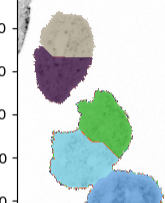.

We could again fix them by tuning the parameters to the watershed function, but this is also a great way to demonstrate the power of Napari for smooth manual image correction. The issue here is not with our mask, but with having too many seed points for our watershed algorithm. By putting our data into the the `correct_watershed` function that we wrote for Napari we will have a smooth interface for correcting these.

(This will not work on binder as it opens in non-browser window)

After calling this function you should something like this:

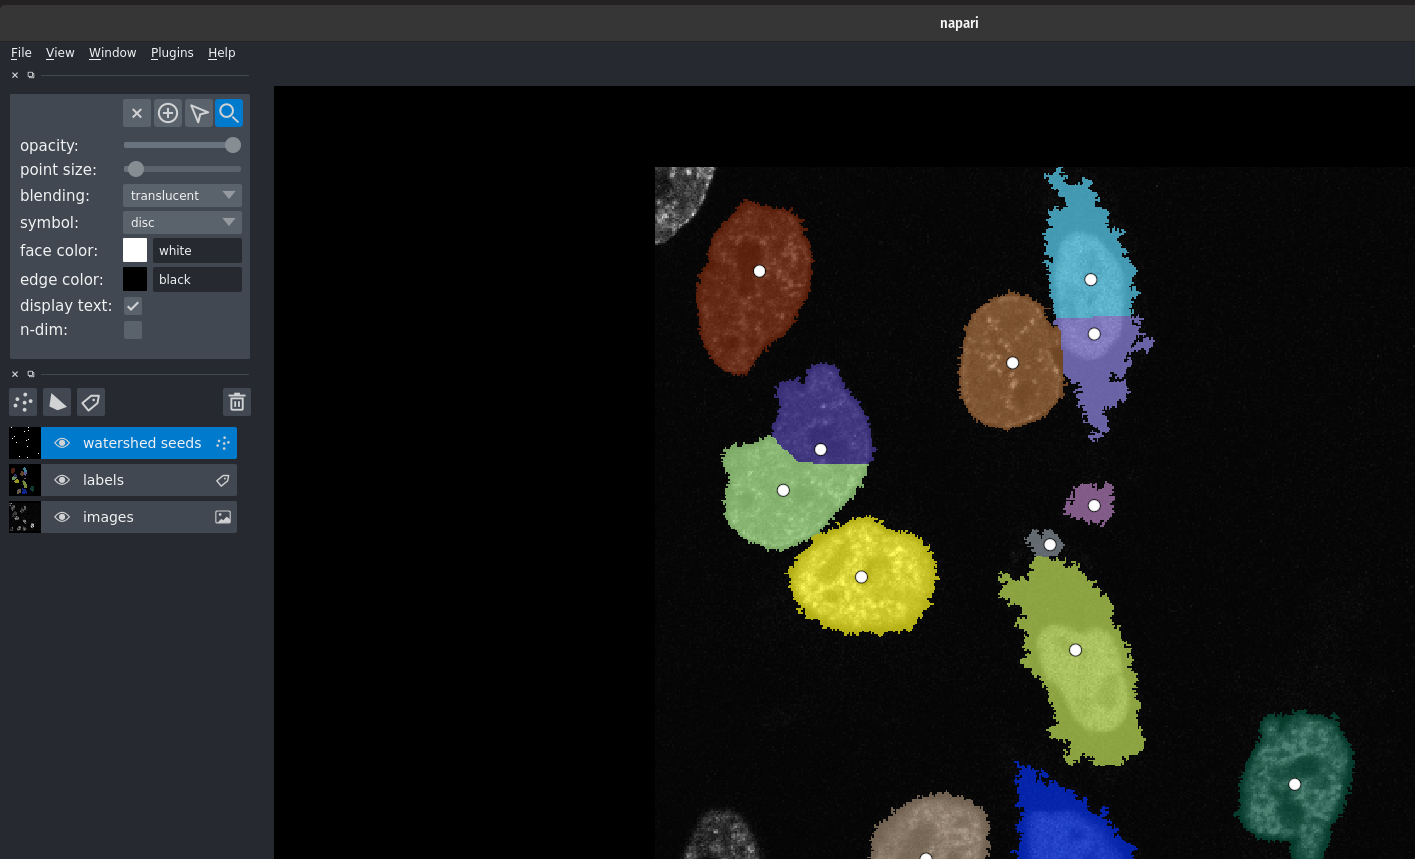

You can use the tools on the left to change whether you are drawing on the labels layer or if you are modifying the seed points. We've also set up a keybinding so if you hit `ctrl+shift+L` the watershed will re-run.



After just removing some seed points and rerunning the watershed we see an image that looks like this:
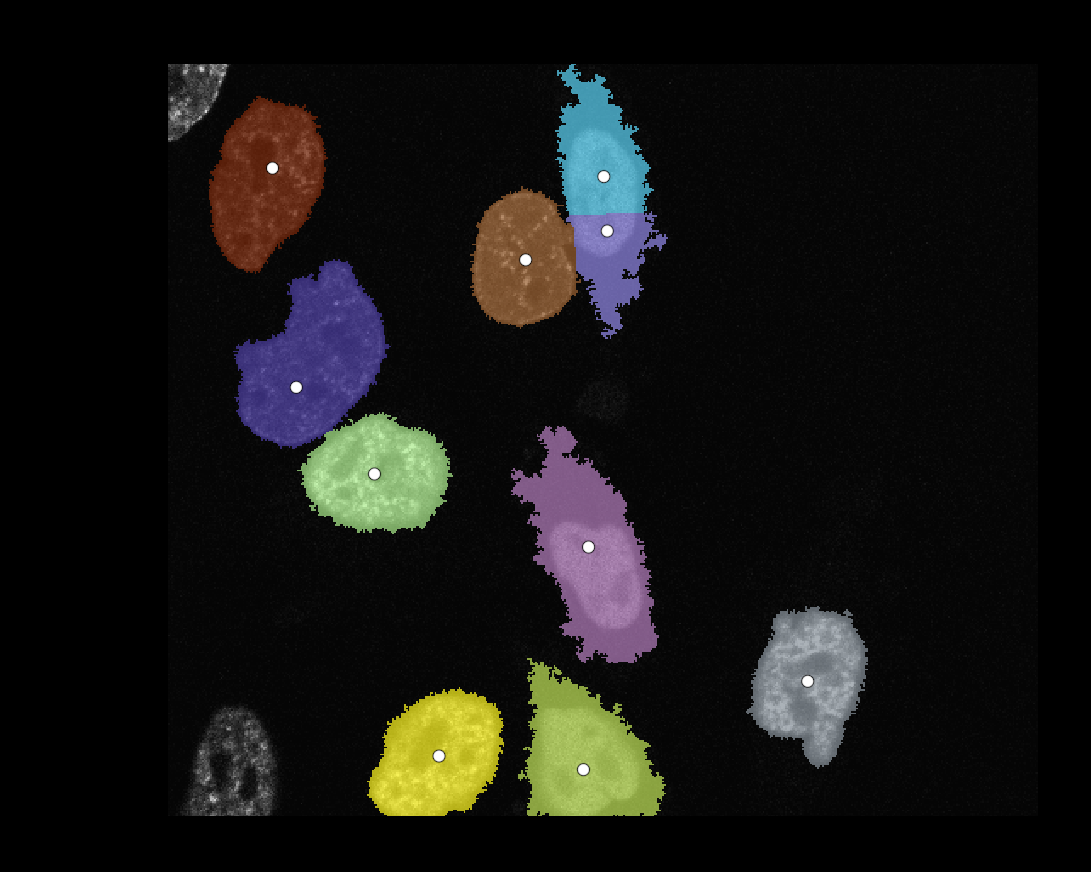

After running the re-watershed the underlying arrays will be automatically updated for you!

In [ ]:
from nesm_utils import correct_watershed

# Use shift+Tab to see the docstring of the function!!
# The docstring contains information about all the helpful keyboard shortcuts
correct_watershed(images, labels, peaks)

### Tracking

Once we have fully corrected the watershed we can track the cells through time. The algorithim we implemented in `nesm_utils` makes use of the tracking problem being analogous to the `linear_sum_assignment` problem in operations research. There is a very fast implementation of the solver for this from scipy:  https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.linear_sum_assignment.html

The important points here are that:
1. Once you understand the math this was very easy to implement with existing tools
2. Now we've written this, and you're free to use it so you can build of this work


As implemented in the utils file the algorithm has the drawback that it requries the number of cells to be monotonically increasing. This means that it will throw an error if you don't fully correct the watershed it may not work well.



In [ ]:
import nesm_utils as nu
tracked = nu.track(labels)

### Breakout exercise

Make a plot of cell area over time. 

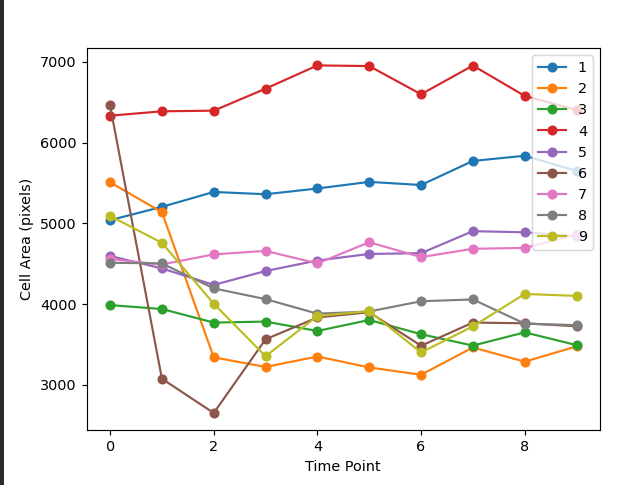





In [ ]:
plt.figure()
for i in range(1,10):
    plt.plot(np.sum(tracked == i, axis=(1,2)), 'o-', label=i)
plt.legend()
plt.xlabel('Time Point')
plt.ylabel('Cell Area (pixels)')


## Closing Thoughts on this section


1. GUI vs Scripting
2. If you make scripts make them available to others!
    - Put up on github with a name
3. If you're at a company - consider open sourcing at least part of your software (see tensorflow)

## How to get help!

Always always always google a phrase that basically says what you want.

labels
labels
Here are some of the things that I googled when making this notebook:
Here are some of the things that I googled when making this notebook:

> how to analyze EDS python

> Cell tracking python

> remove small object skimage


In general people are friendly and want to know how you are using their software and what doesn't work for you:

- https://forum.image.sc/
- https://discourse.matplotlib.org/
- https://stackoverflow.com/
- https://discourse.jupyter.org/
- https://gitter.im/hyperspy/hyperspy

Opening issues!
